# Testing for multi-scale SR.
1) Linking to drive

2) Dataloader and Network specification

3) Multi-tier evaluation

## Import and linking to drive

In [1]:
## Run once to link to google drive using GCP
#!sudo apt-get install google-drive-ocamlfuse
#!sudo add-apt-repository ppa:alessandro-strada/ppa
#!sudo apt-get update
#!sudo apt-get install google-drive-ocamlfuse

In [2]:
!google-drive-ocamlfuse -headless -id=553698332080-4ilebkr6tajj9d4on76a6sfjilo8dbob.apps.googleusercontent.com -secret=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

# Imports

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm

import random

%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize, RandomVerticalFlip, RandomHorizontalFlip, Normalize
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

from pathlib import Path
import re

# Linking up drive and initialization

In [4]:
#Initializing google drive to a folder
if not os.path.exists("./acv"):
  os.makedirs("./acv")

!google-drive-ocamlfuse acv

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [5]:
os.chdir('/content/acv/Courses/COMS 4995-6 - Applied Computer Vision/Group Project/Codebase/AID')

## Parameters

In [6]:
dir_8x4x = '../../Data/AID/Outputs/EDSRp2x_8xto4x-Bicubic_X2_x8tox4_L1loss_lr1e4_04182023/'
dir_4x2x = '../../Data/AID/Outputs/EDSRp2x_4xto2x-Bicubic_X2_x4tox2_L1loss_lr1e4_04182023/'
dir_2x1x = '../../Data/AID/Outputs/EDSRp2x_2xto1x-Bicubic_X2_x2tox1_L1loss_lr1e4_04182023/'

In [7]:
link_to_model = '/Model/edsr_epoch30.pth'

In [8]:
csv_8xtrain = '../../Data/AID/Train1_5class/train_LRx8.csv'
csv_8xvalid = '../../Data/AID/Train1_5class/valid_LRx8.csv'
csv_8xtest = '../../Data/AID/Test1_2class/test_LRx8.csv'

In [9]:
dir_out = '../../Data/AID/Outputs/EDSRp4_eval8xto1x/'
Path(dir_out).mkdir(parents=True, exist_ok=True)

In [10]:
dir_4xvalid = dir_out + '8xto4x_valid'
dir_4xtest = dir_out + '8xto4x_test'
dir_2xvalid = dir_out + '4xto2x_valid'
dir_2xtest = dir_out + '4xto2x_test'

## Setup model and loader

(150, 150)
torch.Size([3, 150, 150])
(150, 150, 3)


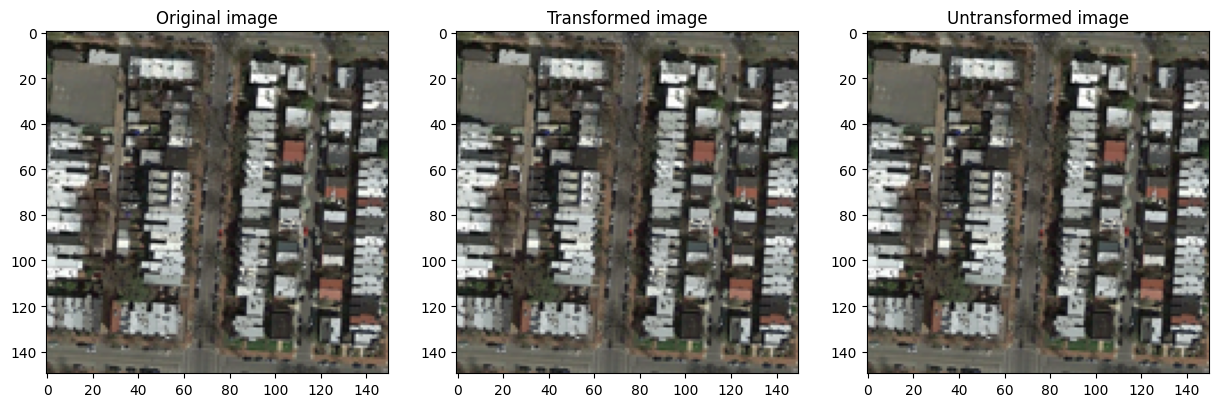

In [11]:
#Transform functions
data_unnormalize = transforms.Compose([
            #transforms.Normalize(mean=[0, 0, 0], std=(1/0.2118,1/0.1872,1/0.1839,)),
            #transforms.Normalize(mean=(-0.3911,-0.4033,-0.3585,), std=[1, 1, 1])
        ])

train_transforms = transforms.Compose([            
            transforms.ToTensor(),            # Convert the image to a tensor
            #Normalize((0.3911,0.4033,0.3585,), (0.2118,0.1872,0.1839,)) 
        ])
flip_transform_vertical = transforms.Compose([
            RandomVerticalFlip(p=1)
        ])

flip_transform_horizontal = transforms.Compose([
            RandomHorizontalFlip(p=1)
        ])
      
test_transforms = transforms.Compose([            
            transforms.ToTensor(),            # Convert the image to a tensor 
            #Normalize((0.3911,0.4033,0.3585,), (0.2118,0.1872,0.1839,))        
        ])

#Unit testing for normalize and unnormalize
img_sample = Image.open('../../Data/AID/AIDx4/DenseResidential/denseresidential_9.png').convert('RGB')
img_sample2 = train_transforms(img_sample)
img_sample3 = data_unnormalize(img_sample2).permute(1, 2, 0).numpy()

print(img_sample.size)
print(img_sample2.shape)
print(img_sample3.shape)

fig, axs = plt.subplots(1, 3, figsize=(15, 10))

# Display the LR and HR images using matplotlib
axs[0].imshow(img_sample)
axs[0].set_title('Original image')
axs[1].imshow(img_sample2.permute(1, 2, 0).numpy())
axs[1].set_title('Transformed image')
axs[2].imshow(img_sample3)
axs[2].set_title('Untransformed image')

plt.show()

In [12]:
class AIDSRDataset(Dataset):
    def __init__(self, dataLR_files, dataHR_files, upscale_factor):
        self.p = 0.5

        self.dataLR_files = np.genfromtxt(dataLR_files,dtype='str')
        self.dataHR_files = np.genfromtxt(dataHR_files,dtype='str')
        self.upscale_factor = upscale_factor
                  
    def __len__(self):
        return len(self.dataLR_files)
    
    def __getitem__(self, idx):
        # Load the image from disk 
        imgLR = Image.open(self.dataLR_files[idx]).convert('RGB') 
        imgHR = Image.open(self.dataHR_files[idx]).convert('RGB')
        
        # Apply the data transformations 
        img_lr = train_transforms(imgLR)
        img_hr = train_transforms(imgHR)

        if random.random() < 0.5:
            img_lr = flip_transform_vertical(img_lr)
            img_hr = flip_transform_vertical(img_hr)

        if random.random() < 0.5:
            img_lr = flip_transform_horizontal(img_lr)
            img_hr = flip_transform_horizontal(img_hr)
        
        return img_lr, img_hr

In [13]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  #device2 = torch.device('cuda:1')
else:
  device = torch.device('cpu')
print(device)
#print(device2)

cuda:0


In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, num_features):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(num_features, num_features, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(num_features, num_features, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(num_features)

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x += residual
        x = self.relu(x)
        return x

class EDSR(nn.Module):
    def __init__(self, scale_factor, num_resblocks, num_channels, num_features):
        super().__init__()
        self.conv1 = nn.Conv2d(3, num_features, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*[
            ResidualBlock(num_features,)
            for _ in range(num_resblocks)
        ])
        self.conv2 = nn.Conv2d(num_features, num_features, kernel_size=3, padding=1)
        self.attention = nn.Sequential(
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        self.desaturation = nn.Sequential( 
            nn.Conv2d(3, 1, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Conv2d(num_features + 1, 3 * scale_factor ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(scale_factor)

    def forward(self, x):
        out = self.conv1(x)
        residual = out
        out = self.resblocks(out)
        out = self.conv2(out)
        out += residual
        attention = self.attention(out)
        out = out * attention
        desat = self.desaturation(x)
        out = torch.cat([out, desat], dim=1)
        out = self.conv3(out)
        out = self.pixel_shuffle(out)
        return torch.clamp(out, 0.0, 1.0)


## Running in chain

In [15]:
test = 1

### X8 to X4

In [16]:
model = EDSR(scale_factor=2, num_resblocks=32, num_channels=3,  num_features = 256).to(device)

saved_state_dict = torch.load(dir_8x4x + link_to_model)
model.load_state_dict(saved_state_dict) # load the saved state_dict into the model


<All keys matched successfully>

In [17]:
##Test data
if test == 1:
  #Create folders for output
  dir_8xto4x = dir_out + '/8xto4x_test/'
  Path(dir_8xto4x).mkdir(parents=True, exist_ok=True)

  #Extracting test data locations 
  list_files = np.genfromtxt(csv_8xtest, dtype='str')

  #Processing test data
  model.eval()
  csv_8xto4x = []

  for file in tqdm(list_files):
      if file == '.':
        continue

      imgLR = Image.open(file).convert('RGB')  

      # Apply the data transformations
      img_lr = train_transforms(imgLR)
      
      output = model(img_lr.unsqueeze(0).to(device))
      img_out = data_unnormalize(output).permute(2, 3, 1, 0).squeeze(3).detach().cpu().numpy() 
      
      # Save the output image
      ind = [m.start() for m in list(re.finditer(r'/',file))]

      im = Image.fromarray(np.uint8(img_out*255))
      im.save(dir_8xto4x + file[ind[-1]+1:])
      
      csv_8xto4x.append(dir_8xto4x + file[ind[-1]+1:])
else:
  ##Validation data
  #Create folders for output
  dir_8xto4x = dir_out + '/8xto4x_valid/'
  Path(dir_8xto4x).mkdir(parents=True, exist_ok=True)

  #Extracting test data locations 
  list_files = np.genfromtxt(csv_8xvalid, dtype='str')

  #Processing test data
  model.eval()
  csv_8xto4x = []

  for file in tqdm(list_files):
      if file == '.':
        continue

      imgLR = Image.open(file).convert('RGB')  

      # Apply the data transformations
      img_lr = train_transforms(imgLR)
      
      output = model(img_lr.unsqueeze(0).to(device))
      img_out = data_unnormalize(output).permute(2, 3, 1, 0).squeeze(3).detach().cpu().numpy() 
      
      # Save the output image
      ind = [m.start() for m in list(re.finditer(r'/',file))]

      im = Image.fromarray(np.uint8(img_out*255))
      im.save(dir_8xto4x + file[ind[-1]+1:])
      
      csv_8xto4x.append(dir_8xto4x + file[ind[-1]+1:])

100%|██████████| 710/710 [29:26<00:00,  2.49s/it]


### 4x to 2x

In [18]:
model = EDSR(scale_factor=2, num_resblocks=32, num_channels=3,  num_features = 256).to(device)

saved_state_dict = torch.load(dir_4x2x + link_to_model)
model.load_state_dict(saved_state_dict) # load the saved state_dict into the model

<All keys matched successfully>

In [19]:
if test == 1:
  files_4xtest = os.listdir(dir_4xtest)
  csv_8xto4x = []
  for file in files_4xtest:
    csv_8xto4x.append(dir_4xtest + '/' + file)
else:
  files_4xvalid = os.listdir(dir_4xvalid)
  csv_8xto4x = []
  for file in files_4xvalid:
    csv_8xto4x.append(dir_4xvalid + '/' + file)


In [21]:
if test == 1:
  ##Validation data
  #Create folders for output
  dir_4xto2x = dir_out + '/4xto2x_test/'
  Path(dir_4xto2x).mkdir(parents=True, exist_ok=True)

  #Extracting test data locations 
  list_files = csv_8xto4x

  #Processing test data
  model.eval()
  csv_4xto2x = []

  for file in tqdm(list_files):
      if file == '.':
        continue

      imgLR = Image.open(file).convert('RGB')  

      # Apply the data transformations
      img_lr = train_transforms(imgLR)
      
      output = model(img_lr.unsqueeze(0).to(device))
      img_out = data_unnormalize(output).permute(2, 3, 1, 0).squeeze(3).detach().cpu().numpy() 
      
      # Save the output image
      ind = [m.start() for m in list(re.finditer(r'/',file))]

      im = Image.fromarray(np.uint8(img_out*255))
      im.save(dir_4xto2x + file[ind[-1]+1:])
      
      csv_4xto2x.append(dir_4xto2x + file[ind[-1]+1:])
else:
  ##Validation data
  #Create folders for output
  dir_4xto2x = dir_out + '/4xto2x_valid/'
  Path(dir_4xto2x).mkdir(parents=True, exist_ok=True)

  #Extracting test data locations 
  list_files = csv_8xto4x

  #Processing test data
  model.eval()
  csv_4xto2x = []

  for file in tqdm(list_files):
      if file == '.':
        continue

      imgLR = Image.open(file).convert('RGB')  

      # Apply the data transformations
      img_lr = train_transforms(imgLR)
      
      output = model(img_lr.unsqueeze(0).to(device))
      img_out = data_unnormalize(output).permute(2, 3, 1, 0).squeeze(3).detach().cpu().numpy() 
      
      # Save the output image
      ind = [m.start() for m in list(re.finditer(r'/',file))]

      im = Image.fromarray(np.uint8(img_out*255))
      im.save(dir_4xto2x + file[ind[-1]+1:])
      
      csv_4xto2x.append(dir_4xto2x + file[ind[-1]+1:])



100%|██████████| 710/710 [32:56<00:00,  2.78s/it]


### 2X to 1X

In [22]:
model = EDSR(scale_factor=2, num_resblocks=16, num_channels=3,  num_features = 256).to(device)

saved_state_dict = torch.load(dir_2x1x + link_to_model)
model.load_state_dict(saved_state_dict) # load the saved state_dict into the model

<All keys matched successfully>

In [23]:
if test == 1:
  files_2xtest = os.listdir(dir_2xtest)
  csv_4xto2x = []
  for file in files_2xtest:
    csv_4xto2x.append(dir_2xtest + '/' + file)
else:
  files_2xvalid = os.listdir(dir_2xvalid)
  csv_4xto2x = []
  for file in files_2xvalid:
    csv_4xto2x.append(dir_2xvalid + '/' + file)


In [24]:
if test == 1:
  ##Test data
  #Create folders for output
  dir_2xto1x = dir_out + '/2xto1x_test/'
  Path(dir_2xto1x).mkdir(parents=True, exist_ok=True)

  #Extracting test data locations 
  list_files = csv_4xto2x

  #Processing test data
  model.eval()
  csv_2xto1x = []

  for file in tqdm(list_files):
      if file == '.':
        continue

      imgLR = Image.open(file).convert('RGB')  

      # Apply the data transformations
      img_lr = train_transforms(imgLR)
      
      output = model(img_lr.unsqueeze(0).to(device))
      img_out = data_unnormalize(output).permute(2, 3, 1, 0).squeeze(3).detach().cpu().numpy() 
      
      # Save the output image
      ind = [m.start() for m in list(re.finditer(r'/',file))]

      im = Image.fromarray(np.uint8(img_out*255))
      im.save(dir_2xto1x  + file[ind[-1]+1:])
      
      csv_2xto1x.append(dir_2xto1x  + file[ind[-1]+1:])
else:
  ##Validation data
  #Create folders for output
  dir_2xto1x = dir_out + '/2xto1x_valid/'
  Path(dir_2xto1x).mkdir(parents=True, exist_ok=True)

  #Extracting test data locations 
  list_files = csv_4xto2x

  #Processing test data
  model.eval()
  csv_2xto1x = []

  for file in tqdm(list_files):
      if file == '.':
        continue

      imgLR = Image.open(file).convert('RGB')  

      # Apply the data transformations
      img_lr = train_transforms(imgLR)
      
      output = model(img_lr.unsqueeze(0).to(device))
      img_out = data_unnormalize(output).permute(2, 3, 1, 0).squeeze(3).detach().cpu().numpy() 
      
      # Save the output image
      ind = [m.start() for m in list(re.finditer(r'/',file))]

      im = Image.fromarray(np.uint8(img_out*255))
      im.save(dir_2xto1x  + file[ind[-1]+1:])
      
      csv_2xto1x.append(dir_2xto1x  + file[ind[-1]+1:])



100%|██████████| 710/710 [33:53<00:00,  2.86s/it]


In [ ]:
halt